## Credit Card Fraud Analysis

### Import the libraries from sklearn and imblearn

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import collections
from collections import Counter
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from pprint import pprint
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_context('notebook')
sns.set_style(style='darkgrid')
%matplotlib inline

Using TensorFlow backend.


### Define common routines

In [3]:
def get_roc(y_test, y_pred):
    #Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristics')
    plt.legend(loc='upper left')
    plt.show()
    return

#This displays a sample confusion matrix and ROC
def analyzePredictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    #------------------------------
    drawConfusionMatrix(cnf_matrix)
    #-----------------------------------------
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    #------------------------------------------
    y_pred_proba = model.predict_proba(X_test)[:,1]
    get_roc(y_test, y_pred_proba)
    
def drawConfusionMatrix(cnf_matrix):
    print(cnf_matrix)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
def printScores(model, X_train, X_test, y_train, y_test):
    y_predict_test = model.predict(X_test)
    y_predict_training = model.predict(X_train)
    print("[Training Classification Report]")
    #print(classification_report(y_train, y_predict_training))
    print("Precision = ", precision_score(y_train, y_predict_training))
    print("Recall = ", recall_score(y_train, y_predict_training))
    print("F1 Score = ", f1_score(y_train, y_predict_training))

    print("")
    print("[Test Classification Report]")
    #print(classification_report(y_test, y_predict_test))
    print("Precision = ", precision_score(y_test, y_predict_test))
    print("Recall = ", recall_score(y_test, y_predict_test))
    print("F1 Score = ", f1_score(y_test, y_predict_test))
    return

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

### Read the credit card fraud data

In [4]:
data = pd.read_csv('C:\Python\Harinee\creditcard.csv')
data.head(10)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


(1) When doing the train/test split, it would be important
to preserver the proportion among the classes in
both sets.

### Split the data to train and test

In [5]:
X = data.drop('Class', axis=1)
y = data['Class']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123, shuffle=True)

did the proportion is reflected in the split of 80 and 20

### Run logistic regression

Logistic Regression
[[56852    12]
 [   39    59]]


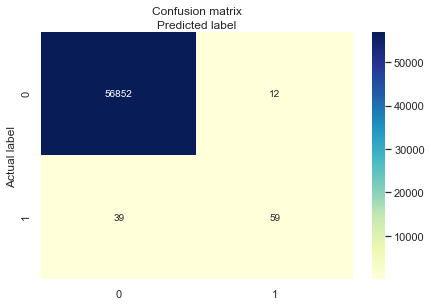

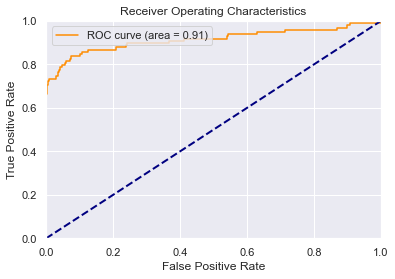

In [35]:
#Logistic Regression
#Use Logistic Regression using the train data, then compute the confusion matrix and the AUC.
print ("Logistic Regression")
def logregclf(X_train, y_train, X_test, y_test):
    model = LogisticRegression(solver='lbfgs', max_iter=500, C=10).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    drawConfusionMatrix(cnf_matrix)    
    y_pred_proba = model.predict_proba(X_test)[:,1]
    get_roc(y_test, y_pred_proba)
    return
logregclf(X_train, y_train, X_test, y_test)


The Model is NOT overfitting. Still run Logistic Regression With A L1 Penalty With Various Regularization Strengths The usefulness of L1 is that it can push feature coefficients to 0, creating a method for feature selection. In the code below we run a logistic regression with a L1 penalty four times, each time decreasing the value of C. We should expect that as C decreases, more coefficients become 0.

### Try with different learning rates C - L1 penalty

In [8]:
C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train, y_train))
    print('Test accuracy:', clf.score(X_test, y_test))
    print('')

C: 10
Coefficient of each feature: [[-3.60476187e-06  8.35624918e-02 -2.04396410e-02 -1.41269536e-02
   6.56172527e-01  1.14440264e-01 -1.04219951e-01 -9.72994275e-02
  -1.67581734e-01 -3.57304484e-01 -8.22698908e-01 -4.95816454e-02
   3.34836686e-02 -2.79823489e-01 -5.57759755e-01 -1.14035634e-01
  -1.13517329e-01 -4.42784504e-02 -1.91966491e-02  1.15852394e-01
  -4.38550629e-01  4.17593266e-01  6.41292804e-01 -4.19805035e-02
   2.36643256e-01 -1.93844948e-01  4.86362103e-02 -8.42083118e-01
  -2.99596928e-01  7.48847573e-04]]
Training accuracy: 0.9985253132612083
Test accuracy: 0.9983497770443454

C: 1
Coefficient of each feature: [[-3.52362971e-06  7.07526218e-02 -1.99994692e-02 -1.19261430e-02
   6.39836266e-01  1.08185081e-01 -9.59436002e-02 -8.37529401e-02
  -1.70035536e-01 -3.38929351e-01 -7.87188110e-01 -3.57931006e-02
   8.85282661e-03 -2.64015598e-01 -5.54107906e-01 -1.07436275e-01
  -1.20038787e-01 -4.42152723e-02 -8.83997262e-03  1.04853947e-01
  -4.02939460e-01  4.02137544e

### Try with different learning rates C - L2 penalty

In [9]:
C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l2', C=c, solver='liblinear')
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train, y_train))
    print('Test accuracy:', clf.score(X_test, y_test))
    print('')

C: 10
Coefficient of each feature: [[-8.94549492e-05  1.97945300e-01 -3.64664126e-01 -8.61960105e-01
   1.58735680e-01 -5.14909084e-02 -7.35502988e-02  9.86330941e-02
  -1.83581205e-01 -4.10982500e-01 -2.45477956e-01 -1.61185372e-01
  -6.15540679e-02 -2.69335138e-01 -7.85484105e-01 -2.71710949e-01
  -3.08136772e-01 -5.24778367e-01 -1.64287697e-02  6.07515605e-02
   6.17315951e-02  1.80028133e-01  2.27952593e-01  4.39481219e-02
  -2.99681458e-02 -2.06601237e-01  3.58380569e-02 -6.03006269e-02
   3.86275464e-02 -7.13067795e-03]]
Training accuracy: 0.8223485264104984
Test accuracy: 0.8215125873389277

C: 1
Coefficient of each feature: [[-8.94481317e-05  1.97857344e-01 -3.64574314e-01 -8.61712755e-01
   1.58700484e-01 -5.14609242e-02 -7.35311976e-02  9.86447918e-02
  -1.83550551e-01 -4.10825002e-01 -2.45395599e-01 -1.61130396e-01
  -6.15682961e-02 -2.69228594e-01 -7.85234636e-01 -2.71654640e-01
  -3.08031107e-01 -5.24579907e-01 -1.64030885e-02  6.07253278e-02
   6.17099745e-02  1.79975582e

So, Now number of coefficients with zero values is zero. So, now it is clear that Ridge regularisation (L2 Regularisation) does not shrink the coefficients to zero.

### Print Classification Report

In [36]:
model = LogisticRegression(solver='lbfgs', max_iter=500, C=10).fit(X_train, y_train)
y_predict_test = model.predict(X_test)
y_predict_training = model.predict(X_train)
print("[Training Classification Report]")
print(classification_report(y_train, y_predict_training))
print("[Test Classification Report]")
print(classification_report(y_test, y_predict_test))

[Training Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.85      0.64      0.73       394

    accuracy                           1.00    227845
   macro avg       0.92      0.82      0.86    227845
weighted avg       1.00      1.00      1.00    227845

[Test Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.60      0.70        98

    accuracy                           1.00     56962
   macro avg       0.92      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962



The classification report metrics are similar in training and Test and it is too good to be true. The reason being due to the imbalanced data set and hence it needs to be addressed.

In [11]:
print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')


No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


### Drop one variable at a time and run the model, to test for accuracy and precision and recall

In [13]:
xAx=[]
accAx=[]
precAx=[]
recAx=[]
f1Ax=[]
for idx, val in enumerate(X_train.columns):
    print("Dropping ", val)
    model = LogisticRegression(solver='lbfgs', max_iter=500, C=10).fit(X_train, y_train)
    X_train_new = X_train.drop(val, axis=1)
    #X_test_new = X_test.drop(val, axis=1)
    model.fit(X_train_new, y_train)
    y_predict_training = model.predict(X_train_new)
    xAx = np.append(xAx, val)
    accAx = np.append(accAx, accuracy_score(y_train, y_predict_training))
    precAx = np.append(precAx, precision_score(y_train, y_predict_training))
    recAx = np.append(recAx, recall_score(y_train, y_predict_training))
    f1Ax = np.append(f1Ax, f1_score(y_train, y_predict_training))


Dropping  Time


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Dropping  V1
Dropping  V2
Dropping  V3
Dropping  V4
Dropping  V5
Dropping  V6
Dropping  V7
Dropping  V8
Dropping  V9


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Dropping  V10
Dropping  V11
Dropping  V12
Dropping  V13
Dropping  V14


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Dropping  V15
Dropping  V16
Dropping  V17
Dropping  V18
Dropping  V19
Dropping  V20


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Dropping  V21
Dropping  V22
Dropping  V23
Dropping  V24
Dropping  V25
Dropping  V26
Dropping  V27
Dropping  V28
Dropping  Amount


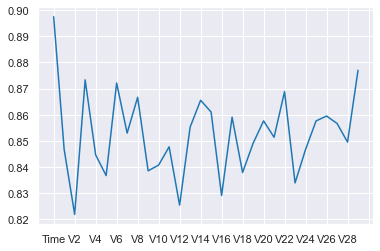

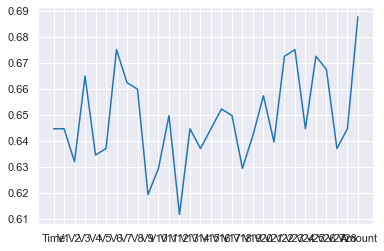

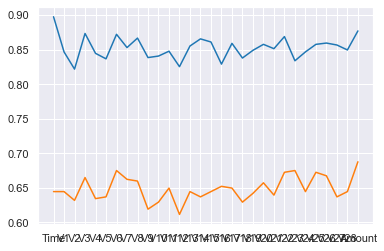

In [16]:
plt.xticks(list(range(0, 100,2))) 
plt.plot(xAx, precAx)
plt.show()
plt.plot(xAx, recAx)
plt.show()
plt.plot(xAx, precAx, recAx)
plt.show()


### Random Undersampling, get both classes 0, 1 to 492 rows

284315 492
1    492
0    492
Name: Class, dtype: int64


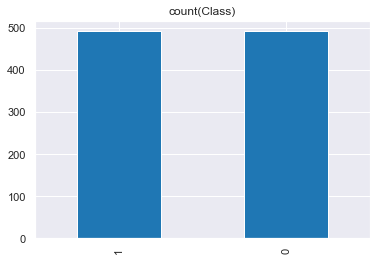

In [18]:
#Random under-sampling:
count_class_0, count_class_1 = data.Class.value_counts()
print(count_class_0, count_class_1 )

df_class_0 = data[data['Class'] == 0]
df_class_1 = data[data['Class'] == 1]
df_class_0_under = df_class_0.sample(count_class_1)
df_data_under = pd.concat([df_class_0_under, df_class_1], axis=0)
#df_data_under has equan number of 0 anf 1 - 492 each
print(df_data_under.Class.value_counts())
df_data_under.Class.value_counts().plot(kind='bar',title = 'count(Class)')

[[91  4]
 [12 90]]


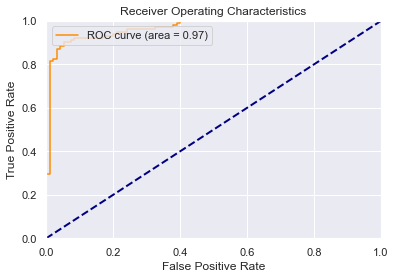

[[385  12]
 [ 27 363]]
Accuracy: 0.9504447268106735
Precision: 0.968
Recall: 0.9307692307692308


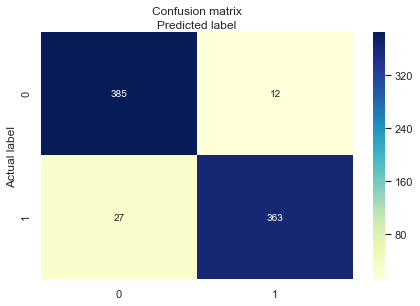

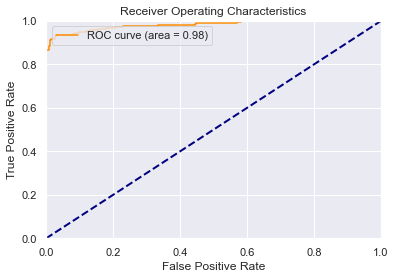

[[91  4]
 [12 90]]


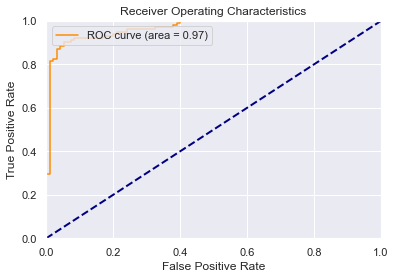

Accuracy =  0.9187817258883249 Precision =  0.9574468085106383 Recall =  0.8823529411764706


In [19]:
X_under = df_data_under.drop('Class', axis=1)
y_under = df_data_under['Class']
X_train_under, X_test_under, y_train_under, y_test_under  = train_test_split(X_under, y_under, test_size = 0.2, random_state=1)

model = LogisticRegression(solver='lbfgs', max_iter=500, C=10).fit(X_train_under, y_train_under)
y_pred_under = model.predict(X_test_under)
print(confusion_matrix(y_test_under, y_pred_under))
y_pred_under_proba = model.predict_proba(X_test_under)[:,1]
get_roc(y_test_under, y_pred_under_proba)
logregclf(X_train_under, y_train_under, X_test_under, y_test_under)

acc_under = accuracy_score(y_test_under, y_pred_under)
prec_under = precision_score(y_test_under, y_pred_under)
rec_under = recall_score(y_test_under, y_pred_under)
print ("Accuracy = ", acc_under, "Precision = ", prec_under, "Recall = ", rec_under)

### Random Oversampling, get both classes 0, 1 to 284315 rows


Random over-sampling:
1    284315
0    284315
Name: Class, dtype: int64


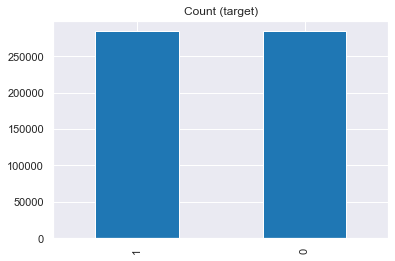

In [20]:
#Random over_sampling:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_data_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_data_over.Class.value_counts())

df_data_over.Class.value_counts().plot(kind='bar', title='Count (target)')

[[54834  2084]
 [ 4985 51823]]


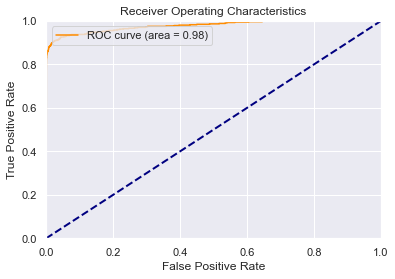

[[219199   8198]
 [ 20414 207093]]
Accuracy: 0.937103212985597
Precision: 0.9619213065107227
Recall: 0.9102708927637392


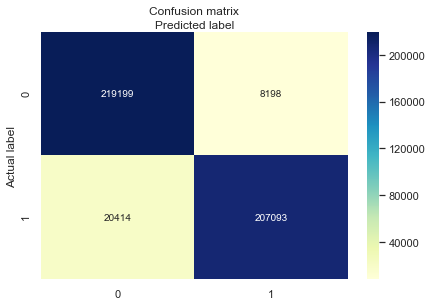

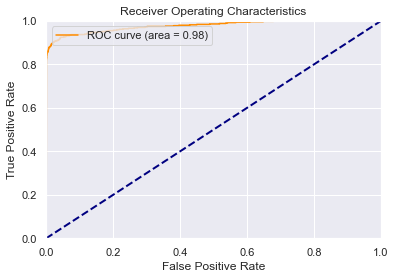

[[54834  2084]
 [ 4985 51823]]


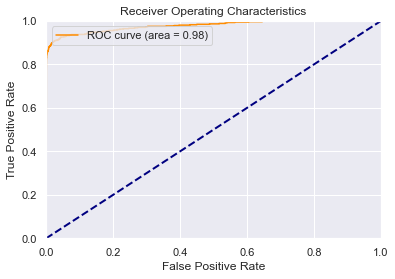

Accuracy =  0.9378418303642088 Precision =  0.9613408277218172 Recall =  0.9122482748908605


In [21]:
X_over = df_data_over.drop('Class', axis=1)
y_over = df_data_over['Class']
X_train_over, X_test_over, y_train_over, y_test_over  = train_test_split(X_over, y_over, test_size = 0.2, random_state=1)

model = LogisticRegression(solver='lbfgs', max_iter=500, C=10).fit(X_train_over, y_train_over)
y_pred_over = model.predict(X_test_over)
print(confusion_matrix(y_test_over, y_pred_over))
y_pred_over_proba = model.predict_proba(X_test_over)[:,1]
get_roc(y_test_over, y_pred_over_proba)
logregclf(X_train_over, y_train_over, X_test_over, y_test_over)

acc_over = accuracy_score(y_test_over, y_pred_over)
prec_over = precision_score(y_test_over, y_pred_over)
rec_over = recall_score(y_test_over, y_pred_over)
print ("Accuracy = ", acc_over, "Precision = ", prec_over, "Recall = ", rec_over)

### Imbalanced Learn Undersampling, get both classes 0, 1 to 492 rows


In [23]:
#IMBLearn Undersampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X,y)

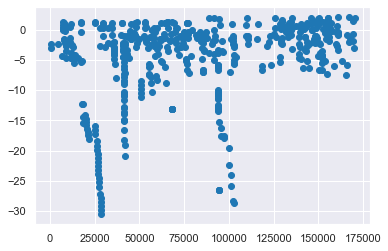

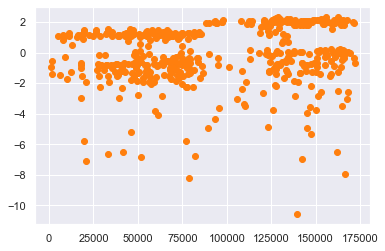

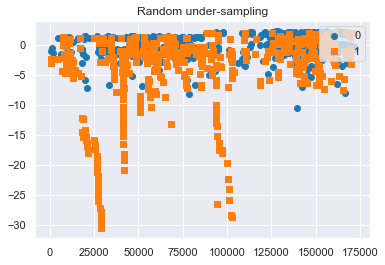

In [24]:
plt.scatter(
            X_rus[y_rus==1, 0],
            X_rus[y_rus==1, 1],
            c='#1F77B4', label=1, marker='o'
        )
plt.show()
plt.scatter(
            X_rus[y_rus==0, 0],
            X_rus[y_rus==0, 1],
            c='#FF7F0E', label=1, marker='o'
        )
plt.show()
plot_2d_space(X_rus, y_rus, 'Random under-sampling')

[[88  7]
 [17 85]]


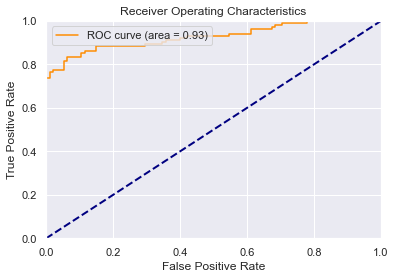

[[380  17]
 [ 40 350]]
Accuracy: 0.9275730622617535
Precision: 0.9536784741144414
Recall: 0.8974358974358975


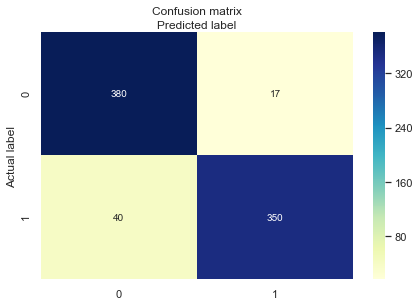

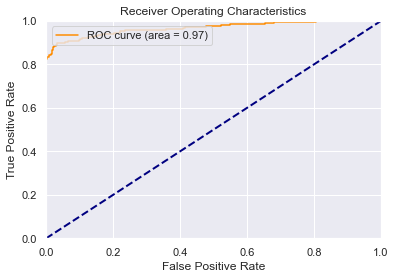

[[88  7]
 [17 85]]


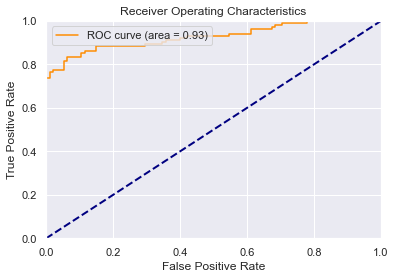

Accuracy =  0.8781725888324873 Precision =  0.9239130434782609 Recall =  0.8333333333333334


In [25]:
X_train_rus, X_test_rus, y_train_rus, y_test_rus  = train_test_split(X_rus, y_rus, test_size = 0.2, random_state=1)

model = LogisticRegression(solver='lbfgs', max_iter=500, C=10).fit(X_train_rus, y_train_rus)
y_pred_rus = model.predict(X_test_rus)
print(confusion_matrix(y_test_rus, y_pred_rus))
y_pred_rus_proba = model.predict_proba(X_test_rus)[:,1]
get_roc(y_test_rus, y_pred_rus_proba)
logregclf(X_train_rus, y_train_rus, X_test_rus, y_test_rus)

acc_rus = accuracy_score(y_test_rus, y_pred_rus)
prec_rus = precision_score(y_test_rus, y_pred_rus)
rec_rus = recall_score(y_test_rus, y_pred_rus)
print ("Accuracy = ", acc_rus, "Precision = ", prec_rus, "Recall = ", rec_rus)

### Imbalanced Learn Oversampling, get both classes 0, 1 to 284315 rows

In [26]:
#IMBLearn Oversampler
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

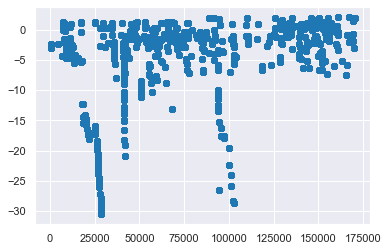

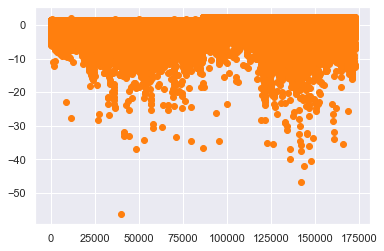

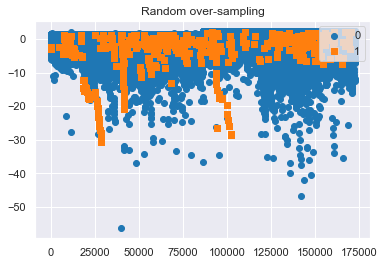

In [27]:
plt.scatter(
            X_ros[y_ros==1, 0],
            X_ros[y_ros==1, 1],
            c='#1F77B4', label=1, marker='o'
        )
plt.show()
plt.scatter(
            X_ros[y_ros==0, 0],
            X_ros[y_ros==0, 1],
            c='#FF7F0E', label=1, marker='o'
        )
plt.show()
plot_2d_space(X_ros, y_ros, 'Random over-sampling')

[[54888  2038]
 [ 5073 51727]]


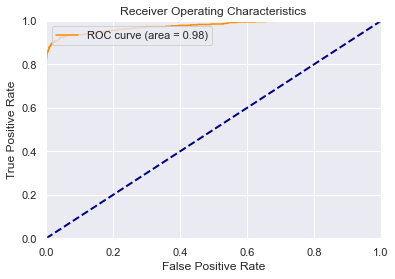

[[219123   8266]
 [ 20447 207068]]
Accuracy: 0.9368811881188119
Precision: 0.961613121940799
Recall: 0.9101290024833527


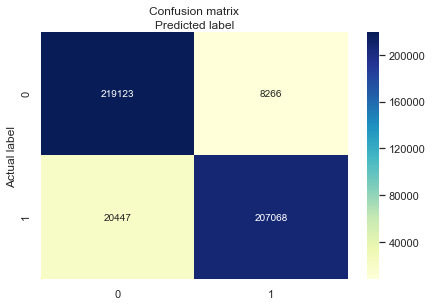

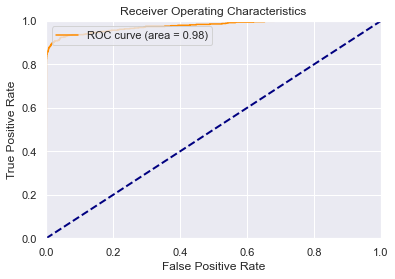

[[54888  2038]
 [ 5073 51727]]


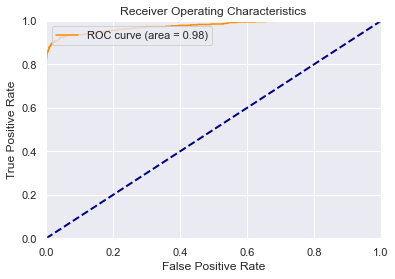

Accuracy =  0.9374725216749028 Precision =  0.9620942992653213 Recall =  0.9106866197183099


In [30]:
X_train_ros, X_test_ros, y_train_ros, y_test_ros  = train_test_split(X_ros, y_ros, test_size = 0.2, random_state=1)

model = LogisticRegression(solver='lbfgs', max_iter=500, C=10).fit(X_train_ros, y_train_ros)
y_pred_ros = model.predict(X_test_ros)
print(confusion_matrix(y_test_ros, y_pred_ros))
y_pred_ros_proba = model.predict_proba(X_test_ros)[:,1]
get_roc(y_test_ros, y_pred_ros_proba)
logregclf(X_train_ros, y_train_ros, X_test_ros, y_test_ros)

acc_ros = accuracy_score(y_test_ros, y_pred_ros)
prec_ros = precision_score(y_test_ros, y_pred_ros)
rec_ros = recall_score(y_test_ros, y_pred_ros)
print ("Accuracy = ", acc_ros, "Precision = ", prec_ros, "Recall = ", rec_ros)

In [32]:
print ("Random Undersampling = " , "Accuracy = ", acc_under, "Precision = ", prec_under, "Recall = ", rec_under)
print ("Random Oversampling = " , "Accuracy = ", acc_over, "Precision = ", prec_over, "Recall = ", rec_over)
print ("IMBlearn RUS = " , "Accuracy = ", acc_rus, "Precision = ", prec_rus, "Recall = ", rec_rus)
print ("IMBlearn ROS = " , "Accuracy = ", acc_ros, "Precision = ", prec_ros, "Recall = ", rec_ros)

Random Undersampling =  Accuracy =  0.9187817258883249 Precision =  0.9574468085106383 Recall =  0.8823529411764706
Random Oversampling =  Accuracy =  0.9378418303642088 Precision =  0.9613408277218172 Recall =  0.9122482748908605
IMBlearn RUS =  Accuracy =  0.8781725888324873 Precision =  0.9239130434782609 Recall =  0.8333333333333334
IMBlearn ROS =  Accuracy =  0.9374725216749028 Precision =  0.9620942992653213 Recall =  0.9106866197183099
